In [ ]:
import requests
import pandas as pd

def get_series(series_id, start, end, api_key='fbf2a3cac76ec733ee2b8c01ab036950', file_type='json'):
    url_base = 'https://api.stlouisfed.org/fred/series/observations'
    url = f'{url_base}?series_id={series_id}'
    if start is not None:
        start = pd.to_datetime(start, errors='raise')
        url += '&observation_start=' + start.strftime('%Y-%m-%d')
    if end is not None:
        end = pd.to_datetime(end, errors='raise')
        url += '&observation_end=' + end.strftime('%Y-%m-%d')
    
    url += f'&api_key={api_key}&file_type={file_type}'
    
    try:
        resp = requests.get(url)
    except  Exception as e:
        print(e)
        return None
    
    dfdict = {}
    for i in resp.json()['observations']:
        dt = pd.to_datetime(i['date'], errors='raise')
        if i['value'] != '.':
            rate = float(i['value'])
        else:
            rate = None
        dfdict[dt] = rate
        
    df = pd.DataFrame.from_dict(dfdict, orient='index', columns=[series_id])
    df.fillna(method='ffill', inplace=True)
    return df

df = get_series('DEXUSUK', '1983-01-01', '2022-12-31')
df.head()

,DEXUSUK
1983-01-03,1.6235
1983-01-04,1.6210
1983-01-05,1.6210
1983-01-06,1.6065
1983-01-07,1.6100


In [ ]:
# df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'], format = '%Y-%m-%d')
# indexed_df = df_fx_data.set_index('Date')

indexed_df = df.copy()
indexed_df.columns = ['Value']
ts_euro = indexed_df['Value']
ts_euro.head(5)


1983-01-03    1.6235
1983-01-04    1.6210
1983-01-05    1.6210
1983-01-06    1.6065
1983-01-07    1.6100
Name: Value, dtype: float64

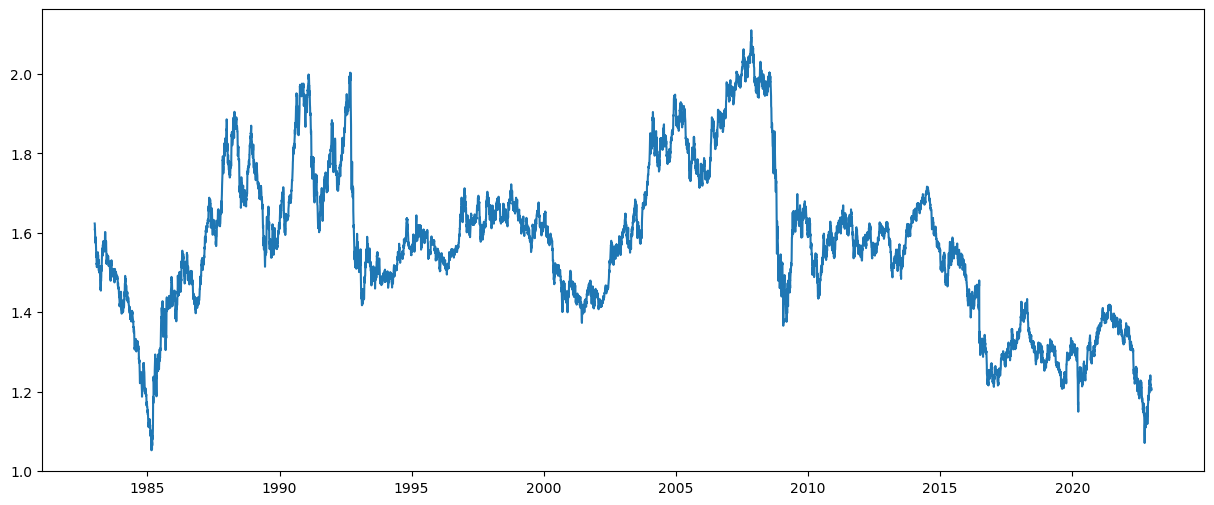

In [ ]:
plt.plot(ts_euro.index.to_pydatetime(), ts_euro.values)


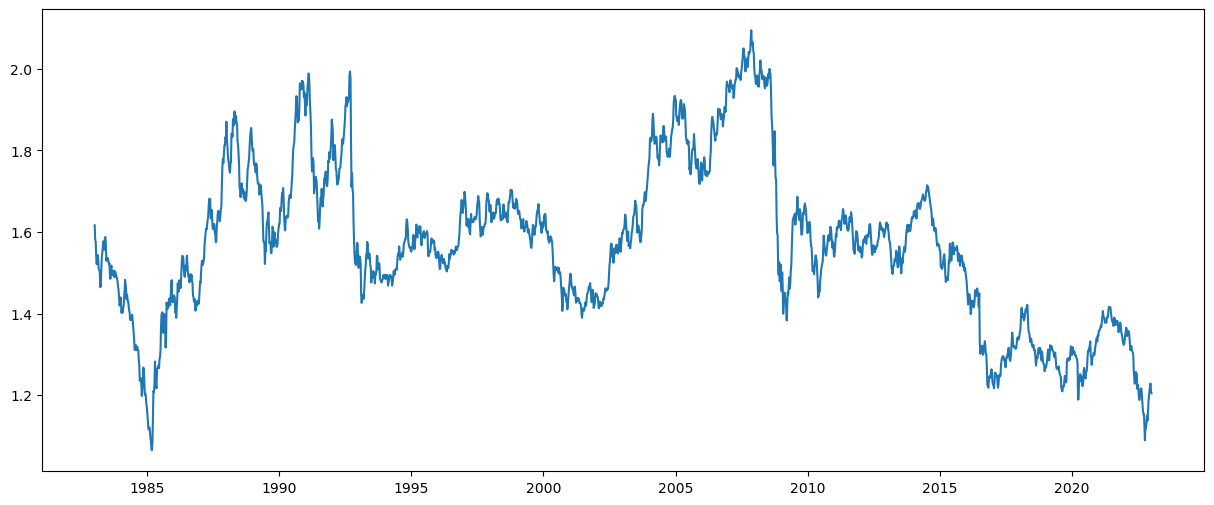

In [ ]:
ts_euro_week = ts_euro.resample('W').mean()
plt.plot(ts_euro_week.index.to_pydatetime(), ts_euro_week.values)

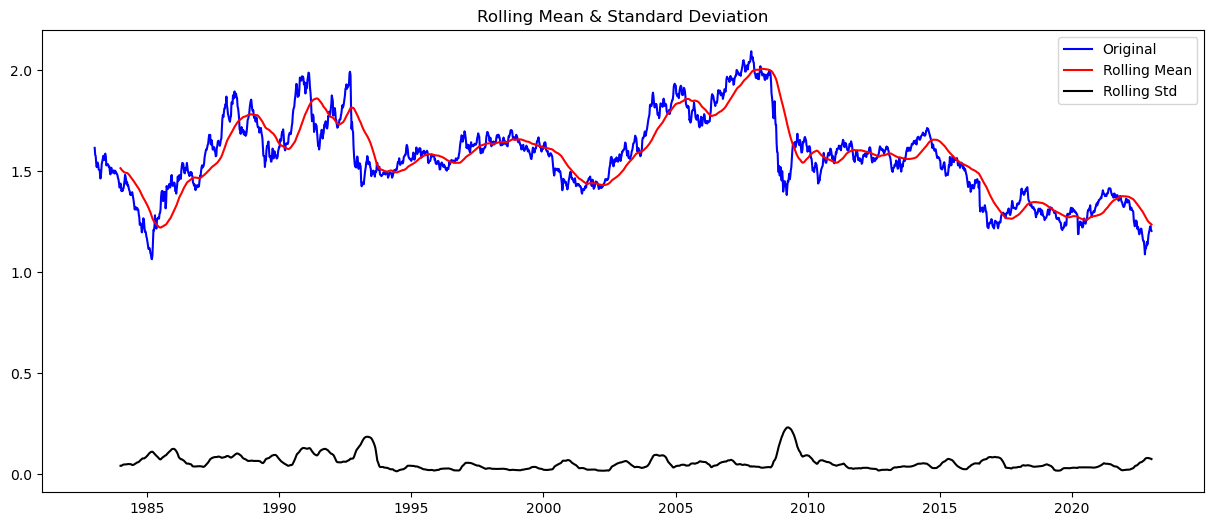

Results of Dickey-Fuller Test:
Test Statistic                   -2.319095
p-value                           0.165883
#Lags Used                        3.000000
Number of Observations Used    2083.000000
Critical Value (1%)              -3.433493
Critical Value (5%)              -2.862929
Critical Value (10%)             -2.567509
dtype: float64


In [ ]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)
check_stationarity(ts_euro_week)


In [ ]:
# Resample the ts_euro series to weekly frequency where week ends on Friday taking the last value of the week

ts_euro_weekly = ts_euro.resample('W-FRI').last()


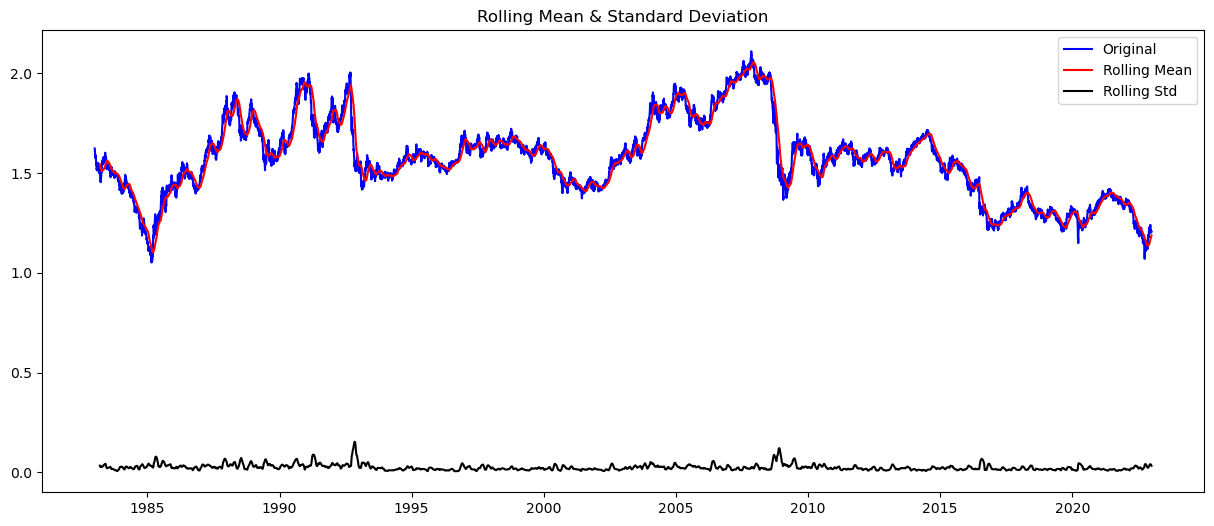

Results of Dickey-Fuller Test:
Test Statistic                    -2.270853
p-value                            0.181541
#Lags Used                         1.000000
Number of Observations Used    10433.000000
Critical Value (1%)               -3.430977
Critical Value (5%)               -2.861817
Critical Value (10%)              -2.566917
dtype: float64


In [ ]:
check_stationarity(ts_euro)

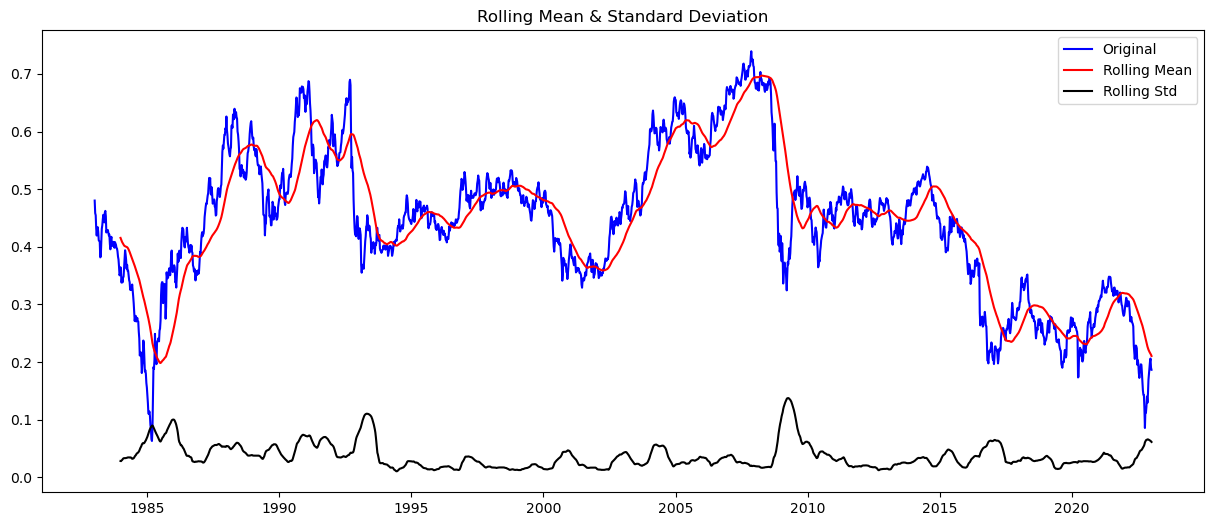

Results of Dickey-Fuller Test:
Test Statistic                   -2.191467
p-value                           0.209357
#Lags Used                        3.000000
Number of Observations Used    2083.000000
Critical Value (1%)              -3.433493
Critical Value (5%)              -2.862929
Critical Value (10%)             -2.567509
dtype: float64


In [ ]:
ts_euro_week_log = np.log(ts_euro_week)
check_stationarity(ts_euro_week_log)


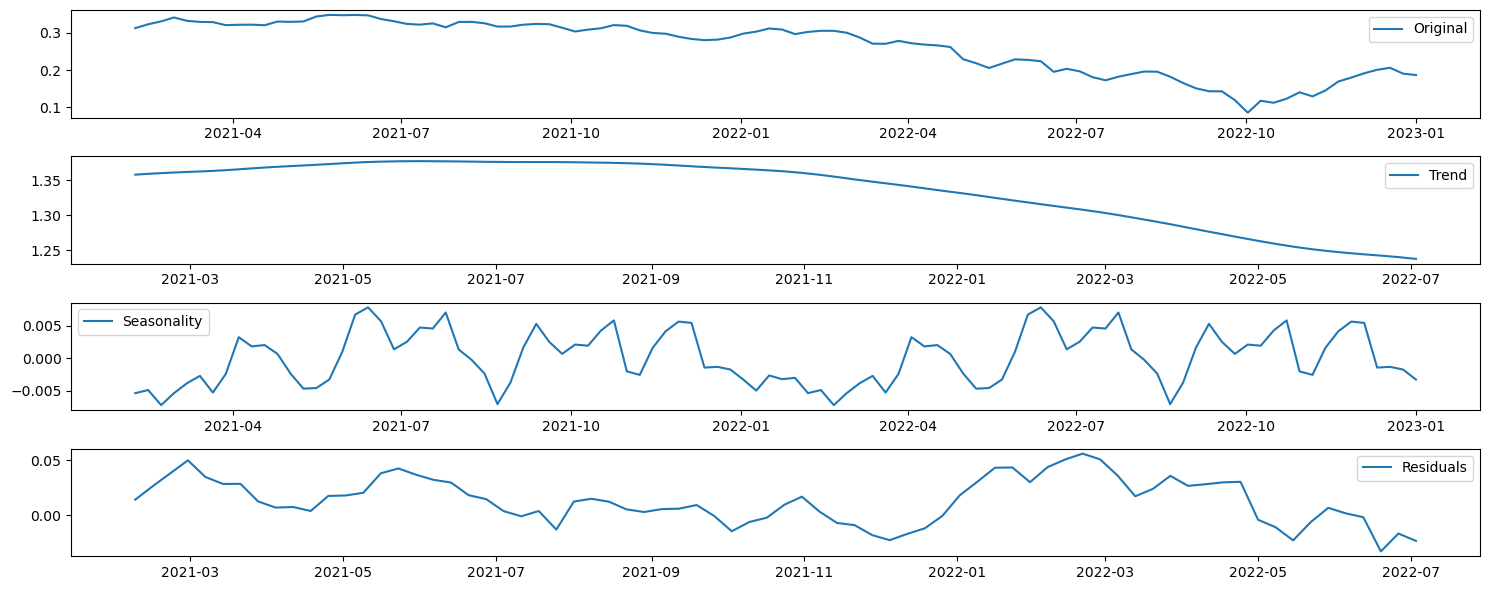

In [ ]:
decomposition = seasonal_decompose(ts_euro_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent weeks 
ts_euro_week_log_select = ts_euro_week_log[-100:]

plt.subplot(411)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), ts_euro_week_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), trend[-100:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), seasonal[-100:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_euro_week_log_select.index.to_pydatetime(), residual[-100:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


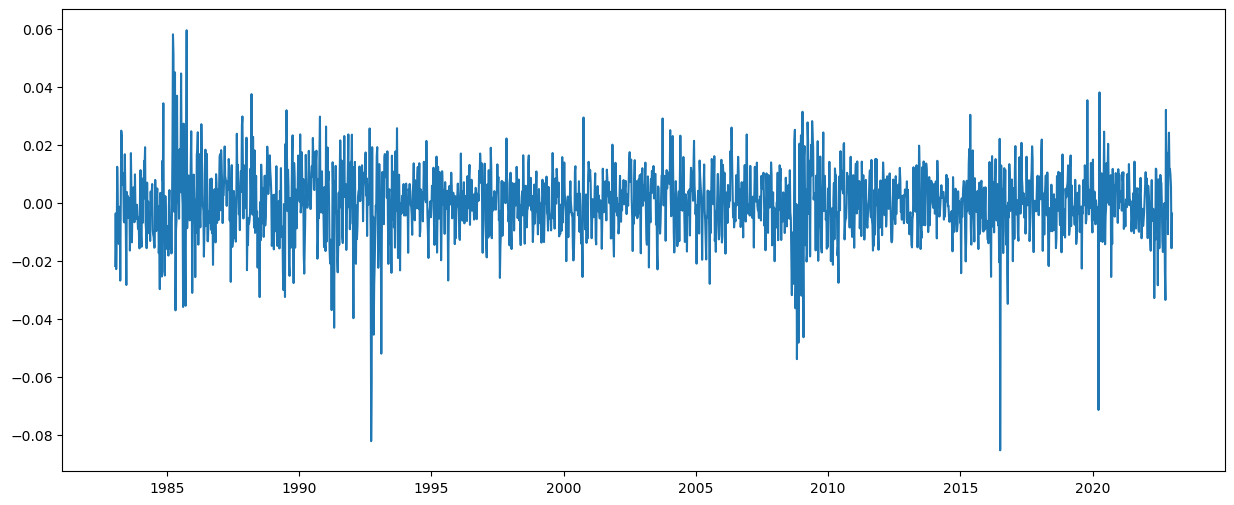

In [ ]:
ts_euro_week_log_diff = ts_euro_week_log - ts_euro_week_log.shift()
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)


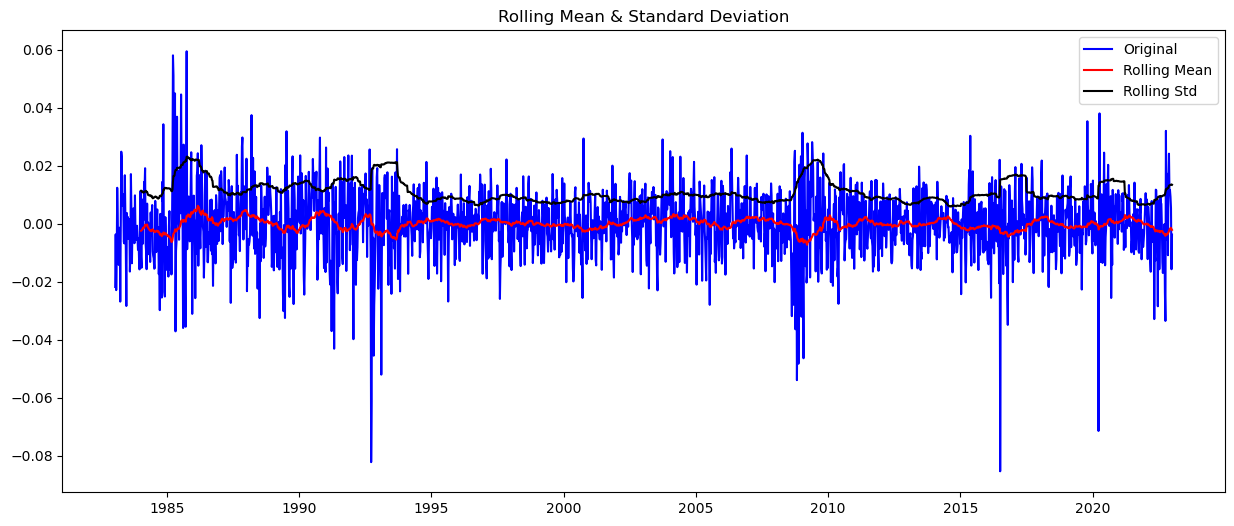

Results of Dickey-Fuller Test:
Test Statistic                  -24.349379
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2083.000000
Critical Value (1%)              -3.433493
Critical Value (5%)              -2.862929
Critical Value (10%)             -2.567509
dtype: float64


In [ ]:
ts_euro_week_log_diff.dropna(inplace=True)
check_stationarity(ts_euro_week_log_diff)


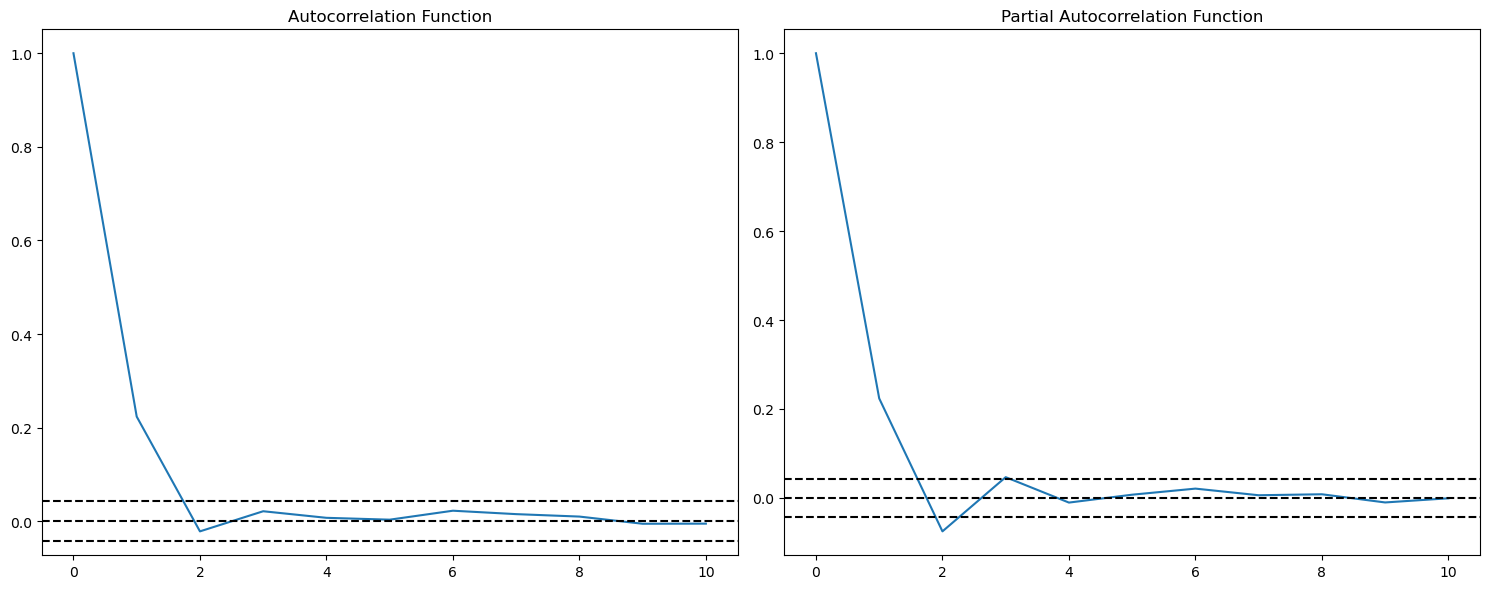

In [ ]:
#ACF and PACF plots

lag_auto_corr = acf(ts_euro_week_log_diff, nlags=10)
lag_par_auto_corr = pacf(ts_euro_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_euro_week_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In [ ]:
model = ARIMA(ts_euro_week_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
model = ARIMA(ts_euro_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)
plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_euro_week_log_diff)**2))
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())
euro_predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (euro_predictions_ARIMA_diff.head())
euro_predictions_ARIMA_diff_cumsum = euro_predictions_ARIMA_diff.cumsum()
euro_predictions_ARIMA_log = pd.Series(ts_euro_week_log.iloc[0], index=ts_euro_week_log.index)
euro_predictions_ARIMA_log = euro_predictions_ARIMA_log.add(euro_predictions_ARIMA_diff_cumsum,fill_value=0)
euro_predictions_ARIMA = np.exp(euro_predictions_ARIMA_log)
plt.plot(ts_euro_week.index.to_pydatetime(), ts_euro_week.values)
plt.plot(ts_euro_week.index.to_pydatetime(), euro_predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((euro_predictions_ARIMA-ts_euro_week)**2)/len(ts_euro_week)))

size = int(len(ts_euro_week_log) - 15)
train, test = ts_euro_week_log[0:size], ts_euro_week_log[size:len(ts_euro_week_log)]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euro Rate = %f, Expected Euro Rate = %f' % (np.exp(yhat), np.exp(observed)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

euro_predictions_series = pd.Series(predictions, index = test.index)

fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_euro_week[-50:], 'o', label='observed')
ax.plot(np.exp(euro_predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')






